# 超密集组网建模

## 针对场景
- 基站
    - 随机分布 / 均匀分布
- 用户
    - 随机分布 / 均匀分布
- $n_{bs} < n_{ue}$

## 两种情况

### Case 1

- 固定用户数，固定基站数

#### Problem 1

- 统计基站的服务范围内大概有多少个用户？

#### Problem 2

- 大概需要多少的带宽？

### Case 2

- 固定基站数，不固定用户数

#### Problem

- 能服务的用户数

## 主要问题

- 资源分配问题

## 分配的资源

- 频带
- 功率

## 涉及到的问题

- 复用问题
- 用户需求的多样性
- 不同频段的聚合

# Case1 - Problem1 分析

- 随机分布的用户，随机分布的基站，固定用户数，固定基站数，统计基站的服务范围内大概有多少个用户。

区域的参数汇总如下表：

|参数|数值|
|:--|:--:|
|基站数|200|
|用户数|1000|
|区域面积|100$\times$100|

# 基站的分布情况的示意图

根据上面的参数，我们就能勾画出基站的分布情况的示意图。基站的示意图如下图所示：

In [14]:
from udntools.region import ServiceRegion
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

In [168]:
service_region = ServiceRegion(0.0, 100.0, 0.0, 100.0, 200, 1000)

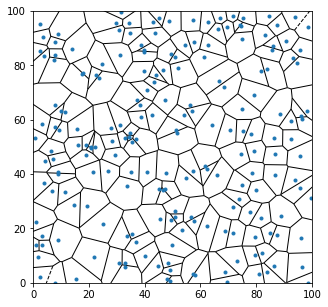

In [169]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
vor = Voronoi(service_region.bs_position_)
voronoi_plot_2d(vor, show_vertices=False, show_points=True, ax=ax)
plt.xlim(service_region.x_min, service_region.x_max)
plt.ylim(service_region.y_min, service_region.y_max)
plt.show()

由于用户也是随机分布的，我们也可以画出用户的分布情况的示意图。如下图所示。

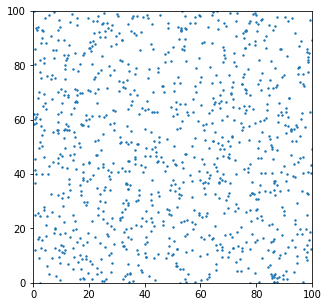

In [170]:
fig = plt.figure(figsize=(5, 5))
ue_x = service_region.ue_position_[0, :]
ue_y = service_region.ue_position_[1, :]
plt.scatter(ue_x, ue_y, s=2, marker='o')
plt.xlim(service_region.x_min, service_region.x_max)
plt.ylim(service_region.y_min, service_region.y_max)
plt.show()

用户均匀的分布在整个区域的周围。

# 每个基站大概需要服务多少个用户？

有了基站的统计分布规律，有了基站的统计分布规律，我们就可以去讨论基站服务的用户数这个统计规律了。首先我们通过画图的方法，对这件事情有一个直观的认识：

我们把不同的基站的服务区域用不同的泰森多边形去表示它，然后我们去观察每个泰森多边形里面到底有多少个用户，示意图如下，其中不同基站所服务的用户尽量用不同的颜色去表示（目前阶段为了简单，相邻不同区域的用户的颜色可能一样）。

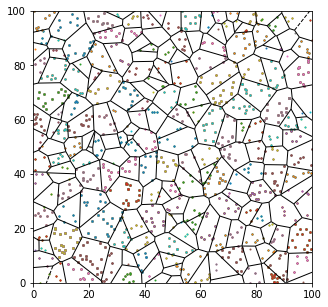

In [171]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in service_region.bs_ue_dict:
    for index in service_region.bs_ue_dict[i]:
        plt.scatter(service_region.ue_position_[[0], service_region.bs_ue_dict[i]],
                    service_region.ue_position_[[1], service_region.bs_ue_dict[i]],
                    s=1, marker='o')
vor = Voronoi(service_region.bs_position_)
voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=ax)
plt.xlim(service_region.x_min, service_region.x_max)
plt.ylim(service_region.y_min, service_region.y_max)
plt.show()

为了有一个直观的认识，我们可以观察这250个基站，去统计基站服务用户数的直方图。

In [172]:
def get_bs_ue_num_list(region):
    bs_ue_num_list = []
    for i in region.bs_ue_dict:
        bs_ue_num_list.append(len(region.bs_ue_dict[i]))
    return bs_ue_num_list

In [173]:
bs_ue_num_list = get_bs_ue_num_list(service_region)

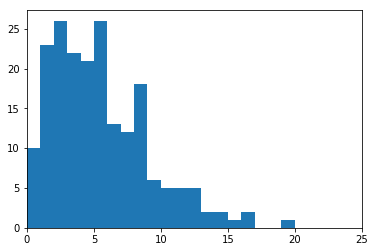

In [178]:
import numpy as np
bins = np.arange(0, 26, 1)
plt.hist(bs_ue_num_list, bins)
plt.xlim(0,25)
plt.show()

点数太少了，统计特性出不来，解决的办法是进行更多次的仿真，画图，给出更准确的统计特性。

In [179]:
from itertools import chain
bs_ue_num_list = []
for i in range(10000):
    region_hist = ServiceRegion(0.0,100.0,0.0,100.0,200,1000)
    bs_ue_num_list.append(get_bs_ue_num_list(region_hist))

bs_ue_num_list = list(chain(*bs_ue_num_list))

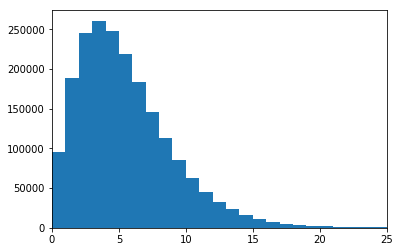

In [180]:
import numpy as np
bins = np.arange(0, 26, 1)
plt.hist(bs_ue_num_list,bins)
plt.xlim(0,25)
plt.show()


很好，统计特性出来了。

看起来像是一个高斯分布的离散情况。离散情况下能逼近高斯分布的也就只有二项分布和泊松分布了。

在进一步推断之前，首先把频率分布直方图进行归一化。

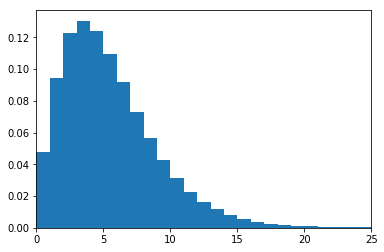

In [181]:
import numpy as np
bins = np.arange(0, 26, 1)
plt.hist(bs_ue_num_list,bins, normed=True)
plt.xlim(0,25)
plt.show()

我们将上述的频率分布直方图，用$\mathcal{B}(1000,1 / 200)$拟合一下试试。其中$\mathcal{B}$表示二项分布，看看能不能拟合上。

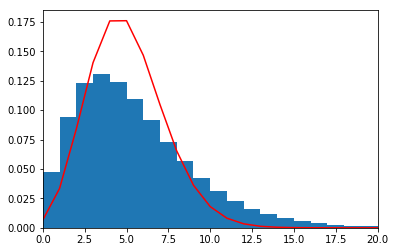

In [186]:
import numpy as np
from scipy import stats
n = 1000
k=np.arange(n+1)
prob=stats.binom(1000, 1.0/200).pmf(k)
plt.plot(k, prob, color='r')
bins = np.arange(0, 26, 1)
plt.hist(bs_ue_num_list,bins, normed=True)
plt.xlim(0,20)
plt.show()

看来拟合不上思密达。

下一步将考虑如何对该问题进行数学上的推导。

# 单个基站下服务用户个数的统计分布规律

因为用户是随机分布的，因此在单位面积上的用户数其实是相等，所以单个基站上有多少个用户，其实可以考虑该基站的服务区域占总共服务区域的百分比。在用该百分比乘以总的用户数就可以的到单个基站下服务的用户数的统计平均值。

换句话说，如果想知道单个基站下服务用户的**概率质量分布函数**，也只需要知道服务区域的面积就行了。

因为整个小区中用户的数量已知，密度就已知了。如果知道单个基站的服务面积。那么单个基站的服务用户数的统计分布规律服从泊松分布。

将上述陈述可以总结成两个命题如下：

**命题一：** 在Case1的情况下，对于小区中的单个小基站而言，如果知道该小基站的服务面积为$\sigma$，用户的密度为$\lambda_{\mathsf{ue}}$，那么该小基站服务用户数$\bar{n}$的统计平均值为:
$$\tag{1}
    \bar{n}=\lambda_{\mathsf{ue}}\sigma
$$

**命题二：** 在Case2的情况下，对于小区中的单个小基站而言，如果知道该小基站的服务面积为$\sigma$，用户的密度为$\lambda_{\mathsf{ue}}$，那么改小基站的服务用户数$n$的概率质量分布函数为：
$$\tag{2}
P(n = k) = \frac{e^{-\lambda_{\mathsf{ue}}\sigma}(\lambda_{\mathsf{ue}}\sigma)^{k}}{k!} 
$$